# Energy A.I. Hackathon 2021 Workflow - [High-Risk-Low-Return] 

Authors: 

Ken Ikeda1, Carolyn Bland1, Kevin Ma2, Daniel Hatchell3
1, Jackson School of Geosciences, Geophysics 
2, Cockrell School of Engineering, ME
3, Cockrell School of Engineering, PGE

The University of Texas at Austin, Austin, Texas USA 

### Executive Summary

Building a data analytics and machine learning workflow to predict cumulative (3 yr) oil production for 10 pre-production wells using existing well data

### Workflow Goal

Integrate expert knowledge, geostatistical methods, and uncertainty modelling into our machine learning workflow to maximize model accuracy

### Workflow Steps  
1. Data analysis
2. Data imputaiton
3. ML model bnuilding and feature importance analysis
4. Uncertainty accessment

## Analysis code (The code starts here)

In [10]:
import pandas as pd 
import numpy as np

import os
import glob 

from pandas_profiling import ProfileReport  ## This lib is used to provide a quick report 

import matplotlib.pyplot as plt

import seaborn as sns

from scipy.interpolate import interp2d
from scipy.interpolate import LinearNDInterpolator
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

## 1. Data visualization

The first part of the code contain the visualization tools of the raw data, necessary for the future analysis.

In [2]:
## Importing data
df_prodHist = pd.read_csv("production_history.csv")

df_preProc = pd.read_csv("wellbore_data_preproduction_well.csv")
df_producer = pd.read_csv("wellbore_data_producer_wells.csv")      #This is the training data

#Horizon/Formation data 
AI = np.load("2d_ai.npy")
sandFraction = np.load("2d_sand_propotion.npy")
sandyShaleFraction = np.load("2d_sandy_shale_propotion.npy")
shaleFraction = np.load("2d_shale_propotion.npy")
shalySandFraction = np.load("2d_shaly_sand_propotion.npy")
topDepth = np.load("2d_top_depth.npy")

#Merge data of two tables 
df_producer_hist = df_producer.merge(df_prodHist, how = 'inner', on = 'Well_ID')

### Horizon plotting

(<Figure size 360x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Top depth'}, xlabel='x [km]', ylabel='y [km]'>)

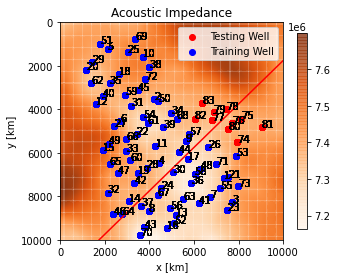

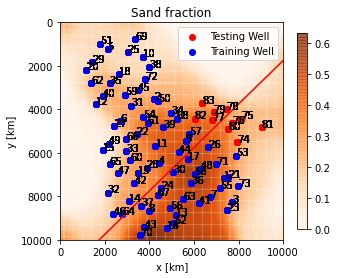

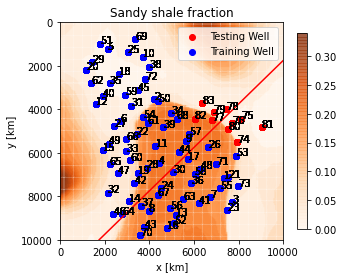

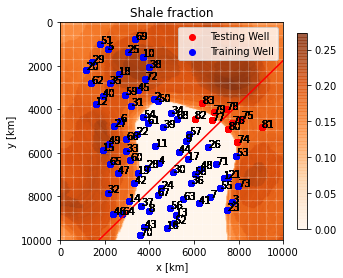

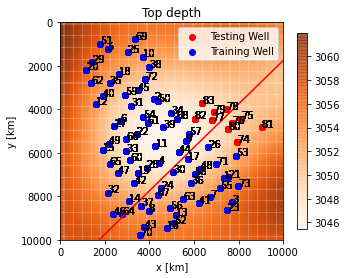

In [6]:
def plotHorizonMap(Zmap = AI, plotTitle = 'Acoustic Impedance'):
    fig, ax = plt.subplots(figsize = (5, 4))

    X = np.linspace(0, 10000, num = AI.shape[0])  #square domain --> X and Y does not matter 
    Y = np.linspace(0, 10000, num = AI.shape[0]) 
    [X, Y] = np.meshgrid(X, Y)

    im0 = ax.pcolormesh(X, Y, Zmap, shading='auto', alpha = 0.5, cmap = 'Oranges') 
    ax.plot([10000, 1750], [1750, 10000], 'r')
    im1 = ax.scatter(df_preProc['X, m'], df_preProc['Y, m'], c = 'red')
    im2 = ax.scatter(df_producer['X, m'], df_producer['Y, m'], c = 'blue')

    #Plotting Well Number
    wellNumberMarker = [x.split("_")[-1] for x in df_producer['Well_ID'].values]
    for i, txt in enumerate(wellNumberMarker):
        ax.annotate(txt, ((df_producer['X, m'][i], df_producer['Y, m'][i])))
    wellNumberMarker = [x.split("_")[-1] for x in df_preProc['Well_ID'].values]
    for i, txt in enumerate(wellNumberMarker):
        ax.annotate(txt, ((df_preProc['X, m'][i], df_preProc['Y, m'][i])))

    ax.set_xlim([0, 10000])
    ax.set_ylim([0, 10000])
    ax.set_xlabel('x [km]')
    ax.set_ylabel('y [km]')
    ax.set_title(plotTitle)
    ax.legend([im1, im2], ['Testing Well', 'Training Well'])

    plt.gca().invert_yaxis()
    fig.colorbar(im0, ax = ax, shrink=0.9)
    
    return fig, ax

plotHorizonMap(Zmap = AI, plotTitle = 'Acoustic Impedance')
plotHorizonMap(Zmap = sandFraction, plotTitle = 'Sand fraction')
plotHorizonMap(Zmap = sandyShaleFraction, plotTitle = 'Sandy shale fraction')
plotHorizonMap(Zmap = shaleFraction, plotTitle = 'Shale fraction')
plotHorizonMap(Zmap = topDepth, plotTitle = 'Top depth')

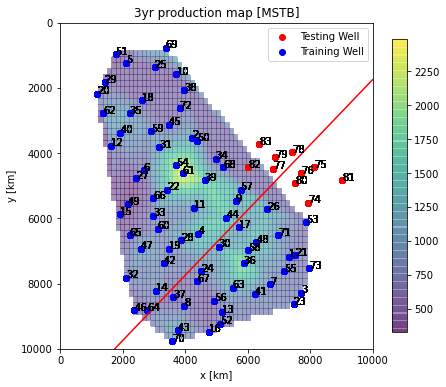

In [4]:
## Interpolating production data 
X_prod3 = df_producer_hist['X, m']
Y_prod3 = df_producer_hist['Y, m']
Z_prod3 = df_producer_hist['Cumulative oil production (3 yr), MSTB']

X_prod3 = np.linspace(min(df_producer_hist['X, m']), max(df_producer_hist['X, m']))
Y_prod3 = np.linspace(min(df_producer_hist['Y, m']), max(df_producer_hist['Y, m']))
X_prod3, Y_prod3 = np.meshgrid(X_prod3, Y_prod3) 
interp = LinearNDInterpolator(list(zip(df_producer_hist['X, m'], df_producer_hist['Y, m'])), df_producer_hist['Cumulative oil production (3 yr), MSTB'])
Z_prod3 = interp(X_prod3, Y_prod3)

fig, ax = plt.subplots(figsize = (7, 6))
im0 = ax.pcolormesh(X_prod3, Y_prod3, Z_prod3, shading='auto', alpha = 0.5) 
ax.plot([10000, 1750], [1750, 10000], 'r')
im1 = ax.scatter(df_preProc['X, m'], df_preProc['Y, m'], c = 'red')
im2 = ax.scatter(df_producer['X, m'], df_producer['Y, m'], c = 'blue')

#Plotting Well Number
wellNumberMarker = [x.split("_")[-1] for x in df_producer['Well_ID'].values]
for i, txt in enumerate(wellNumberMarker):
    ax.annotate(txt, ((df_producer['X, m'][i], df_producer['Y, m'][i])))
wellNumberMarker = [x.split("_")[-1] for x in df_preProc['Well_ID'].values]
for i, txt in enumerate(wellNumberMarker):
    ax.annotate(txt, ((df_preProc['X, m'][i], df_preProc['Y, m'][i])))

ax.set_xlim([0, 10000])
ax.set_ylim([0, 10000])
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('3yr production map [MSTB]')
ax.legend([im1, im2], ['Testing Well', 'Training Well'])

fig.colorbar(im0, ax = ax, shrink=0.9)
plt.gca().invert_yaxis()

### Well logging data plotting 

(<Figure size 1080x468 with 9 Axes>,
 array([<AxesSubplot:xlabel='Porosity (/v)', ylabel='Depth (m)'>,
        <AxesSubplot:xlabel='Perm (mD)'>, <AxesSubplot:xlabel='AI'>,
        <AxesSubplot:xlabel='Density (g/cm3)'>,
        <AxesSubplot:xlabel='Vp (m/s)'>, <AxesSubplot:xlabel='Vs (m/s)'>,
        <AxesSubplot:xlabel='Shear mol (GPa)'>,
        <AxesSubplot:xlabel='Young mol (GPa)'>,
        <AxesSubplot:xlabel='facies'>], dtype=object))

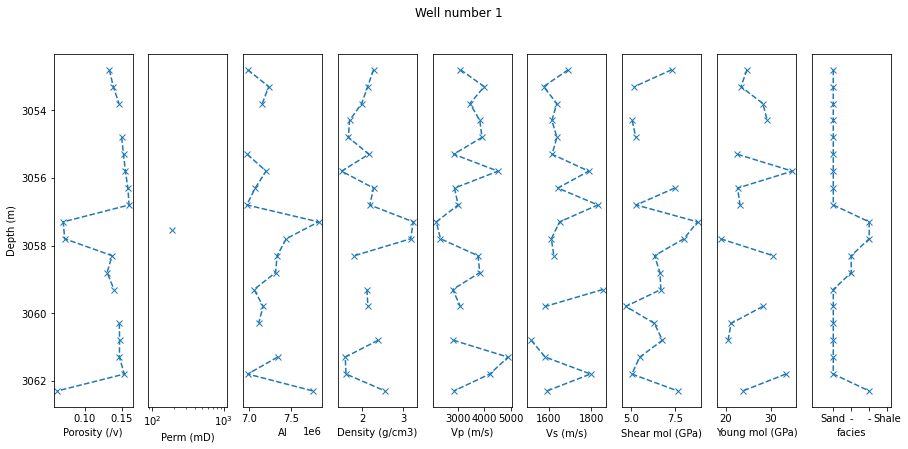

In [7]:
def plotData(df, wellNum = 1):
    df_filt = df[df['Well_ID'] == "Well_no_{}".format(wellNum)]
    
    depth = df_filt['Depth, m']
    
    ##Plotting part
    fig, ax = plt.subplots(nrows = 1, ncols = 9, figsize = (15, 6.5))
    
    ax[0].plot(df_filt['Porosity, fraction'], depth, 'x--')
    ax[0].set_xlabel('Porosity (/v)')
    ax[0].set_ylabel('Depth (m)')
    ax[0].invert_yaxis()
 
    ax[1].plot(df_filt['Permeability, mD'], depth, 'x')
    ax[1].set_xlabel('Perm (mD)')
    ax[1].set_xscale('log')
    ax[1].invert_yaxis()
    ax[1].get_yaxis().set_ticks([])
    
    ax[2].plot(df_filt['Acoustic Impedance, kg*s/m^2'], depth, 'x--')
    ax[2].set_xlabel('AI')
    ax[2].invert_yaxis()
    ax[2].get_yaxis().set_ticks([])

    ax[3].plot(df_filt['Density, g/cm3'], depth, 'x--')
    ax[3].set_xlabel('Density (g/cm3)')
    ax[3].invert_yaxis()
    ax[3].get_yaxis().set_ticks([])
 
    ax[4].plot(df_filt['Compressible velocity, m/s'], depth, 'x--')
    ax[4].set_xlabel('Vp (m/s)')
    ax[4].invert_yaxis()
    ax[4].get_yaxis().set_ticks([])

    ax[5].plot(df_filt['Shear velocity, m/s'], depth, 'x--')
    ax[5].set_xlabel('Vs (m/s)')
    ax[5].invert_yaxis()
    ax[5].get_yaxis().set_ticks([])

    ax[6].plot(df_filt['Shear modulus, GPa'], depth, 'x--')
    ax[6].set_xlabel('Shear mol (GPa)')
    ax[6].invert_yaxis()
    ax[6].get_yaxis().set_ticks([])

    ax[7].plot(df_filt['Youngs modulus, GPa'], depth, 'x--')
    ax[7].set_xlabel('Young mol (GPa)')
    ax[7].invert_yaxis()
    ax[7].get_yaxis().set_ticks([])
    
    faciesDict = {'Sandstone': 1, 'Sandy shale': 3, 'Shaly sandstone': 2, 'Shale': 4, np.nan: np.nan}
    facieLable = [faciesDict[x] for x in df_filt['Rock facies'].values]
    ax[8].plot(facieLable, depth, 'x--')
    ax[8].set_xlabel('facies')
    ax[8].invert_yaxis()
    ax[8].get_yaxis().set_ticks([])
    ax[8].set_xticks([1,2,3,4])
    ax[8].set_xticklabels(['Sand', '-', '-', 'Shale'])
    ax[8].set_xlim([-0.2, 4.2])
    
    plt.suptitle('Well number {}'.format(wellNum))
    
    return fig, ax

plotData(df = df_producer, wellNum = 1)

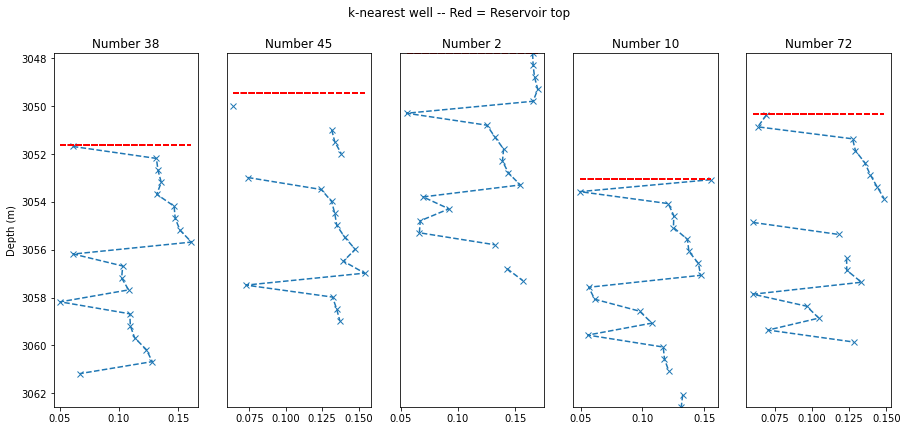

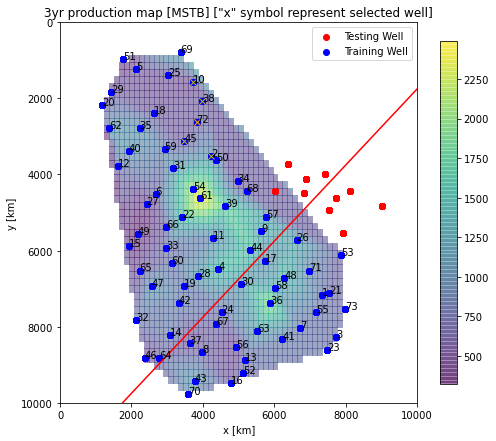

In [9]:
## Plotting the well data of the k-nearest well 
def kNearestWell(df = df_producer, centerWellNumber = 1, k = 5):
    df = df_producer.groupby('Well_ID').agg('mean').reset_index()

    targetWell_X = df[df['Well_ID'] == "Well_no_{}".format(centerWellNumber)]["X, m"]
    targetWell_Y = df[df['Well_ID'] == "Well_no_{}".format(centerWellNumber)]["Y, m"]

    df['distance'] = np.sqrt( (targetWell_X.values - df['X, m'].values)**2 + (targetWell_Y.values - df['Y, m'].values)**2)

    df_sorted = df.sort_values(by = ['distance'], inplace = False)

    return [int(x.split("_")[-1]) for x in df_sorted.iloc[1:(k+1), :]['Well_ID'].values]

def plotLog(df = df_producer, targetLogName = 'Porosity, fraction', centerWellNumber = 1, nearestWellNumber = [21, 55, 73, 71, 7], topRes = topDepth):
    #Note --> topRes --> 2D numpy array of the reservoir depth (horizon!!)
    #dx and dy is the cell spacing of the "topRes" orizon
    
    #adding centerwell as the last item 
    nearestWellNumber.append(centerWellNumber)
    
    #Plot top-depth map 
    X = np.linspace(0, 10000, num = topRes.shape[0])  #square domain --> X and Y does not matter 
    Y = np.linspace(0, 10000, num = topRes.shape[0]) 
    [X, Y] = np.meshgrid(X, Y)
    interp = LinearNDInterpolator(list(zip(X.flatten(), Y.flatten())), topRes.flatten())

    
    fig, ax = plt.subplots(nrows = 1, ncols = len(nearestWellNumber), figsize = (15, 6.5))
    
    minDepth = 1e9
    maxDepth = 0
    
    for wellPlot, plotNum in zip(nearestWellNumber, range(len(nearestWellNumber))):
        #extracted an interested well 
        df_filt = df[df['Well_ID'] == "Well_no_{}".format(wellPlot)]
        depth = df_filt['Depth, m'] 
        
        #standardize depth range for all well
        if np.min(depth.values) < minDepth:
            minDepth = np.min(depth.values)
        if np.max(depth.values) > maxDepth:
            maxDepth = np.max(depth.values)   
        ax[plotNum].plot(df_filt['Porosity, fraction'], depth, 'x--')
        
        #Plot top reservoir horizon
        zResDepth = interp(df_filt['X, m'], df_filt['Y, m'])
        ax[plotNum].plot([np.min(df_filt['Porosity, fraction']), np.max(df_filt['Porosity, fraction'])], [zResDepth, zResDepth], 'r--')
        
        #### cosmetic corrections
        for i in range(len(nearestWellNumber)):
            ax[i].set_ylim([minDepth, maxDepth])
            ax[i].invert_yaxis()
            
        if plotNum == 0:
            ax[plotNum].set_ylabel('Depth (m)')
        else:
            ax[plotNum].get_yaxis().set_ticks([])

        ax[plotNum].set_title('Number {}'.format(wellPlot))
    
    fig.suptitle("k-nearest well -- Red = Reservoir top")

    return fig, ax

def plotNearestMap(df = df_producer, centerWellNumber = 1, wellNumber = [21, 55, 73, 71, 7]):
    df = df.groupby('Well_ID').agg('mean').reset_index()
    df_ML = df.merge(df_prodHist, how = 'inner', on = 'Well_ID')

    wellNumberMarker = [x.split("_")[-1] for x in df_ML['Well_ID'].values]
    
    X_prod3 = df_producer_hist['X, m']
    Y_prod3 = df_producer_hist['Y, m']
    Z_prod3 = df_producer_hist['Cumulative oil production (3 yr), MSTB']

    #from scipy.interpolate import LinearNDInterpolator
    X_prod3 = np.linspace(min(df_producer_hist['X, m']), max(df_producer_hist['X, m']))
    Y_prod3 = np.linspace(min(df_producer_hist['Y, m']), max(df_producer_hist['Y, m']))
    X_prod3, Y_prod3 = np.meshgrid(X_prod3, Y_prod3) 
    interp = LinearNDInterpolator(list(zip(df_producer_hist['X, m'], df_producer_hist['Y, m'])), df_producer_hist['Cumulative oil production (3 yr), MSTB'])
    Z_prod3 = interp(X_prod3, Y_prod3)
    
    fig, ax = plt.subplots(figsize = (8, 7))
    ax.pcolormesh(X_prod3, Y_prod3, Z_prod3, shading='auto', alpha = 0.5) 
    ax.plot([10000, 1750], [1750, 10000], 'r')
    ax.scatter(df_producer['X, m'], df_producer['Y, m'], c = 'blue')
    ax.scatter(df_preProc['X, m'], df_preProc['Y, m'], c = 'red')

    for i, txt in enumerate(wellNumberMarker):
        ax.annotate(txt, ((df_ML['X, m'][i], df_ML['Y, m'][i])))
                    
    #Interested data
    ax.plot(df_ML[df_ML['Well_ID'] == "Well_no_{}".format(centerWellNumber)]['X, m'], df_ML[df_ML['Well_ID'] == "Well_no_{}".format(centerWellNumber)]['Y, m'], 'rx')
    for i in wellNumber:
        ax.plot(df_ML[df_ML['Well_ID'] == "Well_no_{}".format(i)]['X, m'], df_ML[df_ML['Well_ID'] == "Well_no_{}".format(i)]['Y, m'], 'yx')

    ax.set_xlim([0, 10000])
    ax.set_ylim([0, 10000])
    ax.set_xlabel('x [km]')
    ax.set_ylabel('y [km]')
    ax.set_title('3yr production map [MSTB] ["x" symbol represent selected well]')
    ax.legend([im1, im2], ['Testing Well', 'Training Well'])

    fig.colorbar(im0, ax = ax, shrink=0.9)
    plt.gca().invert_yaxis()
    
    return fig, ax 

def plotLogOfKnearestWell(center = 1, k = 5):
    x = kNearestWell(df = df_producer, centerWellNumber = center, k = k)
    plotLog(df = df_producer, targetLogName = 'Porosity, fraction', centerWellNumber = center, nearestWellNumber = x, topRes = topDepth)
    plotNearestMap(df = df_producer, centerWellNumber = center, wellNumber = x)

plotLogOfKnearestWell(center = 72, k = 4)

## 2. Data imputation

In [11]:
## Importing data
df_prodHist = pd.read_csv("production_history.csv")

df_preProc = pd.read_csv("wellbore_data_preproduction_well.csv")
df_producer = pd.read_csv("wellbore_data_producer_wells.csv")      #This is the training data

#Horizon/Formation data 
AI = np.load("2d_ai.npy")
sandFraction = np.load("2d_sand_propotion.npy")
sandyShaleFraction = np.load("2d_sandy_shale_propotion.npy")
shaleFraction = np.load("2d_shale_propotion.npy")
shalySandFraction = np.load("2d_shaly_sand_propotion.npy")
topDepth = np.load("2d_top_depth.npy")

#Merge data of two tables 
df_producer_hist = df_producer.merge(df_prodHist, how = 'inner', on = 'Well_ID')

### Problem with "Young's modulus"

Daniel points out that the given Young's modulus (E) is actually P-wave modulus (M). The data also demonstrates so. And, therefore, we treat the given Young's modulus as P-wave modulus.

Text(0.5, 1.0, 'Pearson corr = -0.032, P = 0.355')

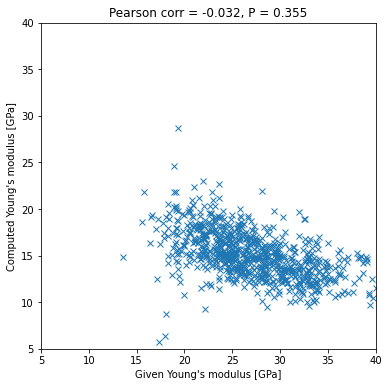

In [13]:
E = df_producer['Youngs modulus, GPa']    #given so-called "Young's modulus"

#Computing the actual Young's modulus 
rho = df_producer['Density, g/cm3'].values*1000        
Vs = df_producer['Shear velocity, m/s'].values
Vp = df_producer['Compressible velocity, m/s'].values

E_computed = rho*Vs**2*(3*Vp**2 - 4*Vs**2)/(Vp**2 - Vs**2)

#Dropping nan value
mask = np.logical_or(np.isnan(E), np.isnan(E_computed))
E = E[~mask]
E_computed = E_computed[~mask]

#compute corr coeff
corr = pearsonr(E, E_computed)


plt.figure(figsize = (6, 6))
plt.plot(E, E_computed/1e9, 'x')
plt.xlim([5, 40])
plt.ylim([5, 40])
plt.xlabel("Given Young's modulus [GPa]")
plt.ylabel("Computed Young's modulus [GPa]")
plt.title("Pearson corr = {:.3f}, P = {:.3f}".format(corr[0], corr[1]))

Text(0.5, 1.0, 'Pearson corr = 0.694, P = 0.000')

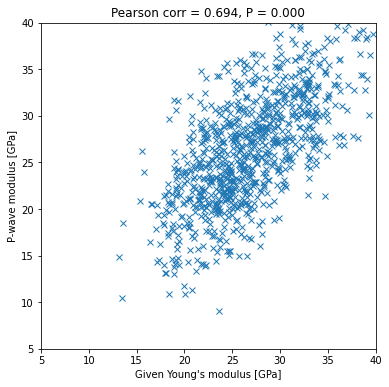

In [14]:
E = df_producer['Youngs modulus, GPa']    #given so-called "Young's modulus"

#Guessing that the "Young' modulus" is mistakenly labelled 
rho = df_producer['Density, g/cm3'].values*1000        
Vs = df_producer['Shear velocity, m/s'].values
Vp = df_producer['Compressible velocity, m/s'].values

M = Vp**2 * rho

#Dropping nan value
mask = np.logical_or(np.isnan(E), np.isnan(M))
E = E[~mask]
M = M[~mask]

#compute corr coeff
corr = pearsonr(E, M)


plt.figure(figsize = (6, 6))
plt.plot(E, M/1e9, 'x')
plt.xlim([5, 40])
plt.ylim([5, 40])
plt.xlabel("Given Young's modulus [GPa]")
plt.ylabel("P-wave modulus [GPa]")
plt.title("Pearson corr = {:.3f}, P = {:.3f}".format(corr[0], corr[1]))

### Checking acoustic impedance 

We check if the acoustic impedance is the P-acoustic impedance or S-acoustic impedance. Apparently, we do not know how the Hackathon organizer computes the acoustic impedance. Both computed P-acoustic impedance and S-acoustic impedance do not show a strong correlation with the given acoustic impedance.  

Text(0.5, 1.0, 'Pearson corr = 0.271, p = 0.0')

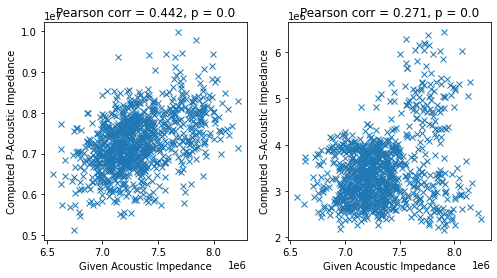

In [15]:
AI = df_producer['Acoustic Impedance, kg*s/m^2']    #given so-called "Young's modulus"

#Computing the actual Young's modulus 
rho = df_producer['Density, g/cm3'].values*1000        
Vs = df_producer['Shear velocity, m/s'].values
Vp = df_producer['Compressible velocity, m/s'].values

AI_P = rho * Vp
AI_S = rho * Vs

#Dropping nan value
AI0 = AI.copy()
mask = np.logical_or(np.isnan(AI0), np.isnan(AI_P))
AI0 = AI0[~mask]
AI_P = AI_P[~mask]

AI = AI.copy()
mask = np.logical_or(np.isnan(AI), np.isnan(AI_S))
AI = AI[~mask]
AI_S = AI_S[~mask]


#compute corr coeff
corr_P = pearsonr(AI0, AI_P)
corr_S = pearsonr(AI, AI_S)


fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].plot(AI0, AI_P, 'x')
ax[0].set_xlabel("Given Acoustic Impedance")
ax[0].set_ylabel("Computed P-Acoustic Impedance")
ax[0].set_title("Pearson corr = {:.3f}, p = {:.1f}".format(corr_P[0], corr_P[1]))

ax[1].plot(AI, AI_S, 'x')
ax[1].set_xlabel("Given Acoustic Impedance")
ax[1].set_ylabel("Computed S-Acoustic Impedance")
ax[1].set_title("Pearson corr = {:.3f}, p = {:.1f}".format(corr_S[0], corr_S[1]))

## Inputation 

### First step --> Equation imputation (Vp, Vs, density, and moduli)
The first step of the data imputation (filling missing value) is based on rock physics equations. Assuming that rock samples are isotropic, the relationship between P-wave velocity ($ V_p $), S-wave velocity ($ V_s $), Shear modulus ($ \mu $), P-wave modulus ($ M $), and density ($ \rho $) is:

$$
V_p = \sqrt{\frac{M} {\rho}} \\
V_s = \sqrt{\frac{\mu} {\rho}}
$$

Note that rocks have poisson's ratio greater than 0. Therefore, under the isotropic assumpion, the following inequality must hold:
$$
\frac{V_p}{V_s} \geq \sqrt{2}
$$

In [18]:
##Start imputation 
df_producer_imputed = df_producer.copy()

##Physics-controlled imputation --> using rock physics equations to impute data

##### Vs = sqrt(shearModulus / density)
#Impute shear modulus USING shear velocity and density 
mask = df_producer_imputed['Shear modulus, GPa'].isna()
df_producer_imputed.loc[mask, 'Shear modulus, GPa'] =  1000*df_producer_imputed[mask]['Density, g/cm3']*df_producer_imputed[mask]['Shear velocity, m/s']**2/1e9
#Impute shear velocity USING shear modulus and density 
mask = df_producer_imputed['Shear velocity, m/s'].isna()
df_producer_imputed.loc[mask, 'Shear velocity, m/s'] = np.sqrt(df_producer_imputed[mask]['Shear modulus, GPa']*1e9 / df_producer_imputed[mask]['Density, g/cm3']/1000)

##### NOTE THAT YOUNG's Modulus SHOULD BE P-WAVE modulus 

##### Vp = sqrt( (K + 4/3mu) / density) = sqrt(M/ density)
#Impute "Young's modulus" from P-velocity (Compressible velocity)  
mask = df_producer_imputed['Youngs modulus, GPa'].isna()
df_producer_imputed.loc[mask, 'Youngs modulus, GPa'] = 1000*df_producer_imputed[mask]['Density, g/cm3']*df_producer_imputed[mask]['Compressible velocity, m/s']**2/1e9
#Impute P-velocity (Compressible velocity) from "Young's modulus"
mask = df_producer_imputed['Compressible velocity, m/s'].isna()
df_producer_imputed.loc[mask, 'Compressible velocity, m/s'] = np.sqrt(df_producer_imputed[mask]['Youngs modulus, GPa']*1e9 / df_producer_imputed[mask]['Density, g/cm3']/1000)


##### Imputing density from Vp
mask = df_producer_imputed['Density, g/cm3'].isna()
df_producer_imputed.loc[mask, 'Density, g/cm3'] = df_producer_imputed[mask]['Youngs modulus, GPa']*1e9 / df_producer_imputed[mask]['Compressible velocity, m/s']**2 / 1000

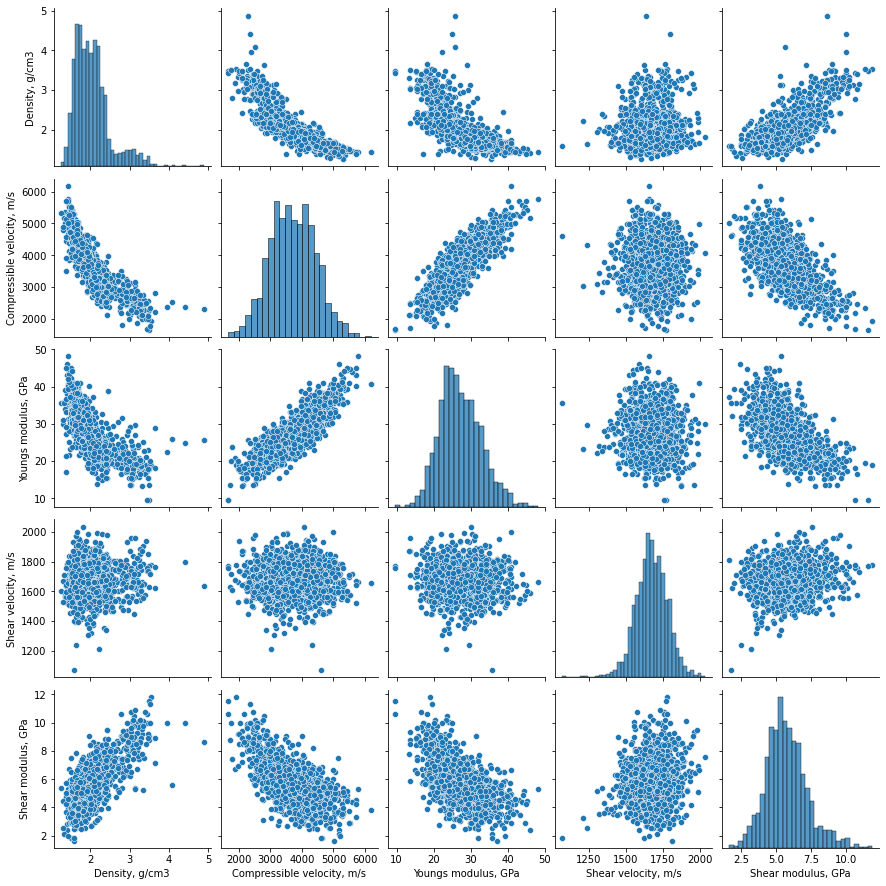

In [19]:
## Checking imputation data before moving forward
sns.pairplot(df_producer_imputed[['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa']])

In [20]:
## Statistics checking 
df_producer_imputed.describe()

,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2","Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
count,1460.000000,1460.000000,1460.000000,1268.000000,284.000000,1.357000e+03,1417.000000,1415.000000,1407.000000,1410.000000,1421.000000
mean,4188.698630,5770.890411,3055.810959,0.127746,112.182739,7.325786e+06,2.051543,3701.209495,27.207492,1675.765333,5.758870
std,1771.495039,2389.773641,4.353335,0.036020,80.894436,3.101125e+05,0.449881,721.546485,5.633797,107.209256,1.501275
min,1175.000000,775.000000,3045.620000,0.040270,2.214604,6.559277e+06,1.255980,1661.828496,9.562034,1069.298522,1.650985
25%,2925.000000,3825.000000,3052.720000,0.113953,51.540980,7.111056e+06,1.723442,3194.503128,23.340885,1607.376885,4.762031
50%,3875.000000,6125.000000,3055.790000,0.137495,93.980722,7.274333e+06,1.978284,3674.753166,26.580455,1675.421416,5.615064
75%,5325.000000,7625.000000,3058.982500,0.152325,154.584890,7.503378e+06,2.233306,4219.335682,30.865723,1747.740881,6.600503
max,7975.000000,9775.000000,3066.300000,0.188910,489.219402,8.249272e+06,4.879421,6179.653016,48.123292,2035.772029,11.820038


### Second step --> Rock facies imputation (classify rock with Vp, Vs, density, and moduli)

The second step fills missing values using statistical approach. First, we fill the rock facies with the elastic attributes (i.e., Vp, Vs, moduli) and the density. To do so, we transform the rock facies log from vategorical value into a range from 0 to 1 where 1 represents shale and 0 represent sand. This is similar to the clay content log (Vclay). Then, imputing these values with other log. 

In [22]:
#Finding the missing  value in the Rock facies and use kNN to impute the data
featureList = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa']

# 0 - 1 scaling 
df_scaled = df_producer_imputed[featureList].copy()
df_scaled_target = df_producer_imputed['Rock facies']

df_scaled = (df_scaled - df_scaled.min() )/(df_scaled.max() - df_scaled.min())

##### Splitting known rows VS unknown rows
##training 
df_knownValue = df_scaled[~df_scaled_target.isna()]
df_knownValue_target = df_scaled_target[~df_scaled_target.isna()]
#drop nan
mask1 = df_knownValue.isna().any(axis = 1)
df_knownValue_1 = df_knownValue[~mask1]
df_knownValue_target_1 = df_knownValue_target[~mask1]

##testing 
df_unknownValue = df_scaled[df_scaled_target.isna()]
#drop nan
mask2 = df_unknownValue.isna().any(axis = 1)
df_unknownValue_2 = df_unknownValue[~mask2]

#kNN classification 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(df_knownValue_1, df_knownValue_target_1)

kNNprediction = neigh.predict(df_unknownValue_2)

##assemble everything back to the original dataframe 
mask = np.logical_and(df_producer_imputed['Rock facies'].isna(), ~df_producer_imputed[featureList].isna().any(axis = 1))
df_producer_imputed.loc[mask, 'Rock facies'] = kNNprediction

In [23]:
## Create a numerical 'Vclay' log
df_producer_imputed['Vclay'] = df_producer_imputed['Rock facies']
df_producer_imputed['Vclay'].replace({'Sandstone': 0, 'Shaly sandstone': 0.3333, 'Sandy shale': 0.6667, 'Shale': 1, np.nan: np.nan}, inplace = True)

### Third step --> Filling acoustic impedance

In [24]:
featureList = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa']

# 0 - 1 scaling 
df_scaled = df_producer_imputed[featureList].copy()
df_scaled_target = df_producer_imputed['Acoustic Impedance, kg*s/m^2']

df_scaled = (df_scaled - df_scaled.min() )/(df_scaled.max() - df_scaled.min())

##### Splitting known rows VS unknown rows
##training 
df_knownValue = df_scaled[~df_scaled_target.isna()]
df_knownValue_target = df_scaled_target[~df_scaled_target.isna()]
#drop nan
mask1 = df_knownValue.isna().any(axis = 1)
df_knownValue_1 = df_knownValue[~mask1]
df_knownValue_target_1 = df_knownValue_target[~mask1]

##testing 
df_unknownValue = df_scaled[df_scaled_target.isna()]
#drop nan
mask2 = df_unknownValue.isna().any(axis = 1)
df_unknownValue_2 = df_unknownValue[~mask2]

#Random forest regressor 
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 100, max_depth = 4)
regr.fit(df_knownValue_1, df_knownValue_target_1)

randomForestprediction = regr.predict(df_unknownValue_2)

##assemble everything back to the original dataframe 
mask = np.logical_and(df_producer_imputed['Acoustic Impedance, kg*s/m^2'].isna(), ~df_producer_imputed[featureList].isna().any(axis = 1))
df_producer_imputed.loc[mask, 'Acoustic Impedance, kg*s/m^2'] = randomForestprediction

### Fourth step --> Filling porosity

To impute the missing porosty, the data are, first, separated into three catagories: sandstone+shaly sandstone, sandy shale, and shale. Each catagory is imputed with the randomforest regression technique.

In [26]:
faciesList = ['Sandstone', 'Sandy shale', 'Shaly sandstone', 'Shale']
featureList = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa']

df_All = []

for facie in faciesList:
    print(facie)
    df = df_producer_imputed[df_producer_imputed['Rock facies'] == facie].copy()
    

    # 0 - 1 scaling 
    df_scaled = df[featureList].copy()
    df_scaled_target = df['Porosity, fraction']

    df_scaled = (df_scaled - df_scaled.min() )/(df_scaled.max() - df_scaled.min())

    ##### Splitting known rows VS unknown rows
    ##training 
    df_knownValue = df_scaled[~df_scaled_target.isna()]
    df_knownValue_target = df_scaled_target[~df_scaled_target.isna()]
    #drop nan
    mask1 = df_knownValue.isna().any(axis = 1)
    df_knownValue_1 = df_knownValue[~mask1]
    df_knownValue_target_1 = df_knownValue_target[~mask1]

    ##testing 
    df_unknownValue = df_scaled[df_scaled_target.isna()]
    #drop nan
    mask2 = df_unknownValue.isna().any(axis = 1)
    df_unknownValue_2 = df_unknownValue[~mask2]

    #Random forest regressor 
    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(n_estimators = 100, max_depth = 4)
    regr.fit(df_knownValue_1, df_knownValue_target_1)

    randomForestprediction = regr.predict(df_unknownValue_2)

    ##assemble everything back to the original dataframe 
    mask = np.logical_and(df['Porosity, fraction'].isna(), ~df[featureList].isna().any(axis = 1))
    df.loc[mask, 'Porosity, fraction'] = randomForestprediction
    
    df_All.append(df)

df_merged = pd.concat([df_All[0], df_All[1], df_All[2], df_All[3]],axis=0).sort_values(['Well_ID','Depth, m'])

Sandstone
Sandy shale
Shaly sandstone
Shale


### Fifth step --> Filling permeability

To impute the missing porosty, the data are, first, separated into three catagories: sandstone+shaly sandstone, sandy shale, and shale. Each catagory is imputed with the randomforest regression technique.

In [29]:
faciesList = ['Sandstone', 'Sandy shale', 'Shaly sandstone', 'Shale']
featureList = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa', 'Porosity, fraction']

df_All = []

for facie in faciesList:
    print(facie)
    df = df_producer_imputed[df_producer_imputed['Rock facies'] == facie].copy()
    

    # 0 - 1 scaling 
    df_scaled = df[featureList].copy()
    df_scaled_target = df['Permeability, mD']

    df_scaled = (df_scaled - df_scaled.min() )/(df_scaled.max() - df_scaled.min())

    ##### Splitting known rows VS unknown rows
    ##training 
    df_knownValue = df_scaled[~df_scaled_target.isna()]
    df_knownValue_target = df_scaled_target[~df_scaled_target.isna()]
    #drop nan
    mask1 = df_knownValue.isna().any(axis = 1)
    df_knownValue_1 = df_knownValue[~mask1]
    df_knownValue_target_1 = df_knownValue_target[~mask1]

    ##testing 
    df_unknownValue = df_scaled[df_scaled_target.isna()]
    #drop nan
    mask2 = df_unknownValue.isna().any(axis = 1)
    df_unknownValue_2 = df_unknownValue[~mask2]

    #Random forest regressor 
    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(n_estimators = 150, max_depth = 6)
    regr.fit(df_knownValue_1, df_knownValue_target_1)

    randomForestprediction = regr.predict(df_unknownValue_2)

    ##assemble everything back to the original dataframe 
    mask = np.logical_and(df['Permeability, mD'].isna(), ~df[featureList].isna().any(axis = 1))
    df.loc[mask, 'Permeability, mD'] = randomForestprediction
    
    df_All.append(df)

df_merged = pd.concat([df_All[0], df_All[1], df_All[2], df_All[3]],axis=0).sort_values(['Well_ID','Depth, m'])

Sandstone
Sandy shale
Shaly sandstone
Shale


In [30]:
def plotData(df, wellNum = 1):
    df_filt = df[df['Well_ID'] == "Well_no_{}".format(wellNum)]
    
    depth = df_filt['Depth, m']
    
    ##Plotting part
    fig, ax = plt.subplots(nrows = 1, ncols = 9, figsize = (15, 6.5))
    
    ax[0].plot(df_filt['Porosity, fraction'], depth, 'x--')
    ax[0].set_xlabel('Porosity (/v)')
    ax[0].set_ylabel('Depth (m)')
    ax[0].invert_yaxis()
 
    ax[1].plot(df_filt['Permeability, mD'], depth, 'x')
    ax[1].set_xlabel('Perm (mD)')
    ax[1].set_xscale('log')
    ax[1].invert_yaxis()
    ax[1].get_yaxis().set_ticks([])
    
    ax[2].plot(df_filt['Acoustic Impedance, kg*s/m^2'], depth, 'x--')
    ax[2].set_xlabel('AI')
    ax[2].invert_yaxis()
    ax[2].get_yaxis().set_ticks([])

    ax[3].plot(df_filt['Density, g/cm3'], depth, 'x--')
    ax[3].set_xlabel('Density (g/cm3)')
    ax[3].invert_yaxis()
    ax[3].get_yaxis().set_ticks([])
 
    ax[4].plot(df_filt['Compressible velocity, m/s'], depth, 'x--')
    ax[4].set_xlabel('Vp (m/s)')
    ax[4].invert_yaxis()
    ax[4].get_yaxis().set_ticks([])

    ax[5].plot(df_filt['Shear velocity, m/s'], depth, 'x--')
    ax[5].set_xlabel('Vs (m/s)')
    ax[5].invert_yaxis()
    ax[5].get_yaxis().set_ticks([])

    ax[6].plot(df_filt['Shear modulus, GPa'], depth, 'x--')
    ax[6].set_xlabel('Shear mol (GPa)')
    ax[6].invert_yaxis()
    ax[6].get_yaxis().set_ticks([])

    ax[7].plot(df_filt['Youngs modulus, GPa'], depth, 'x--')
    ax[7].set_xlabel('Young mol (GPa)')
    ax[7].invert_yaxis()
    ax[7].get_yaxis().set_ticks([])
    
    faciesDict = {'Sandstone': 1, 'Sandy shale': 3, 'Shaly sandstone': 2, 'Shale': 4, np.nan: np.nan}
    facieLable = [faciesDict[x] for x in df_filt['Rock facies'].values]
    ax[8].plot(facieLable, depth, 'x--')
    ax[8].set_xlabel('facies')
    ax[8].invert_yaxis()
    ax[8].get_yaxis().set_ticks([])
    ax[8].set_xticks([1,2,3,4])
    ax[8].set_xticklabels(['Sand', '-', '-', 'Shale'])
    ax[8].set_xlim([-0.2, 4.2])
    
    plt.suptitle('Well number {}'.format(wellNum))
    
    return fig, ax

(<Figure size 1080x468 with 9 Axes>,
 array([<AxesSubplot:xlabel='Porosity (/v)', ylabel='Depth (m)'>,
        <AxesSubplot:xlabel='Perm (mD)'>, <AxesSubplot:xlabel='AI'>,
        <AxesSubplot:xlabel='Density (g/cm3)'>,
        <AxesSubplot:xlabel='Vp (m/s)'>, <AxesSubplot:xlabel='Vs (m/s)'>,
        <AxesSubplot:xlabel='Shear mol (GPa)'>,
        <AxesSubplot:xlabel='Young mol (GPa)'>,
        <AxesSubplot:xlabel='facies'>], dtype=object))

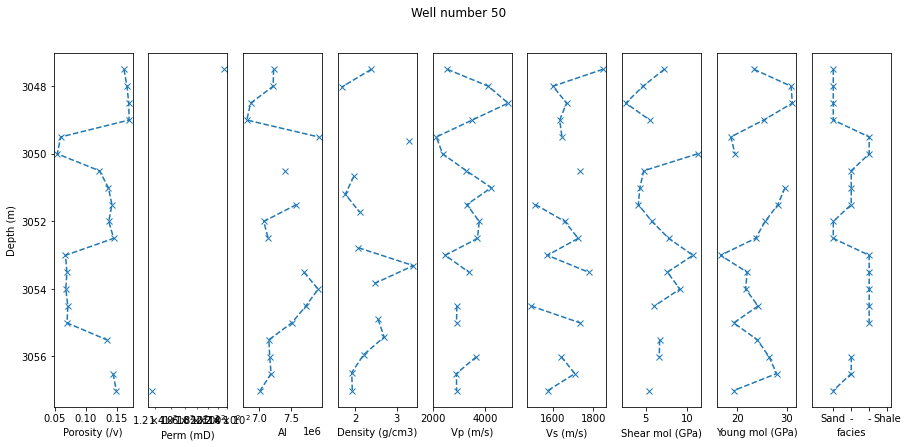

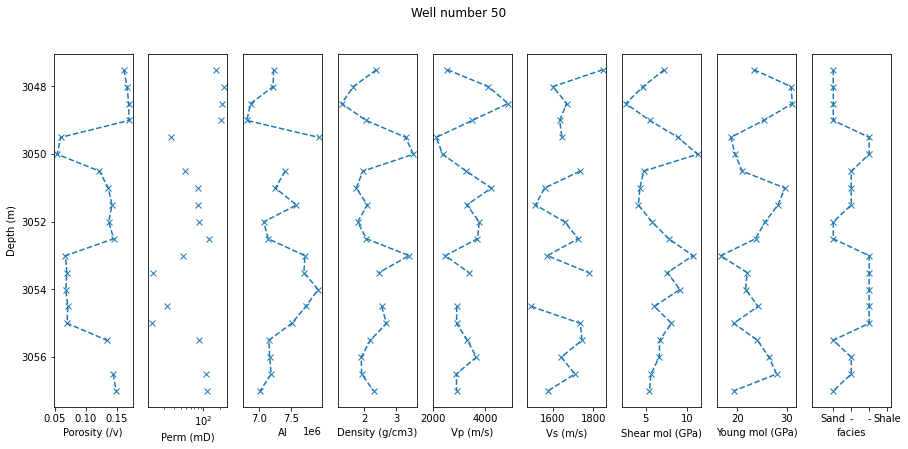

In [31]:
plotData(df = df_producer, wellNum = 50)
plotData(df = df_merged, wellNum = 50)

<AxesSubplot:xlabel='Porosity, fraction', ylabel='Permeability, mD'>

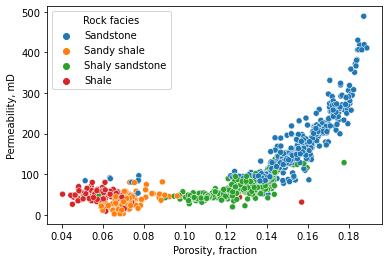

In [32]:
plt.figure()
sns.scatterplot(data = df_merged, x = 'Porosity, fraction', y = 'Permeability, mD', hue = 'Rock facies')

In [ ]:
##Split the data back to two csv files -- Un comment for outputs 
'''
preProducer_Well_ID = ['Well_no_{}'.format(x) for x in range(74, 84)]

df_preProducer_imputed = df_merged[df_merged['Well_ID'].isin(preProducer_Well_ID)]
df_producer_imputed = df_merged[~df_merged['Well_ID'].isin(preProducer_Well_ID)]

df_preProducer_imputed.to_csv("IMPUTED_wellbore_data_preproducer.csv")
df_producer_imputed.to_csv("IMPUTED_wellbore_data_producer.csv")
'''

## 3. Machine learning 

We compared several machine learning algorithms such as ramdom forest regressor, linear regression, and kNN regressor. The hyperparemeters are tuned with the gridsearch cross-validation technique. And, the final solution is validated with 5-fold cross validation.

In [33]:
df_preProducer_imputed = pd.read_csv("IMPUTED_wellbore_data_preproducer.csv", index_col=[0]).drop("Rock facies", axis = 1)
df_producer_imputed = pd.read_csv("IMPUTED_wellbore_data_producer.csv", index_col=[0]).drop("Rock facies", axis = 1)

df_merge = pd.concat([df_preProducer_imputed, df_producer_imputed],axis=0).sort_values(['Well_ID', 'Depth, m'])

df_merge_scaled = df_merge.copy()

df_merge_scaled['X, m'] = df_merge['X, m']/10000 
df_merge_scaled['Y, m'] = df_merge['Y, m']/10000 

def minMaxScaling(df, targetFeature):
    return ( df[targetFeature] - df[targetFeature].min() ) / ( df[targetFeature].max() - df[targetFeature].min())

def logMinMaxScaling(df, targetFeature):
    return ( np.log(df[targetFeature]) - np.log(df[targetFeature]).min() ) / ( np.log(df[targetFeature]).max() - np.log(df[targetFeature]).min() )


df_merge_scaled['Depth, m'] = minMaxScaling(df_merge, 'Depth, m')
df_merge_scaled['Porosity, fraction'] = minMaxScaling(df_merge, 'Porosity, fraction')
df_merge_scaled['Density, g/cm3'] = minMaxScaling(df_merge, 'Density, g/cm3')
df_merge_scaled['Permeability, mD'] = logMinMaxScaling(df_merge, 'Permeability, mD')
df_merge_scaled['Acoustic Impedance, kg*s/m^2'] = minMaxScaling(df_merge, 'Density, g/cm3')
df_merge_scaled['Compressible velocity, m/s'] = minMaxScaling(df_merge, 'Compressible velocity, m/s')
df_merge_scaled['Youngs modulus, GPa'] = minMaxScaling(df_merge, 'Youngs modulus, GPa')
df_merge_scaled['Shear velocity, m/s'] = minMaxScaling(df_merge, 'Shear velocity, m/s')
df_merge_scaled['Shear modulus, GPa'] = minMaxScaling(df_merge, 'Shear modulus, GPa')
df_merge_scaled['Vclay'] = minMaxScaling(df_merge, 'Vclay')


## Putting the data back  
preProducer_Well_ID = ['Well_no_{}'.format(x) for x in range(74, 84)]
df_preProducer_imputed_scale = df_merge_scaled[df_merge_scaled['Well_ID'].isin(preProducer_Well_ID)]
df_producer_imputed_scale = df_merge_scaled[~df_merge_scaled['Well_ID'].isin(preProducer_Well_ID)]

In [34]:
df_prodHist = pd.read_csv("production_history.csv")

## Training dataset 
df_agg_producer = df_producer_imputed_scale.copy()
df_agg_producer = df_agg_producer.groupby("Well_ID").agg("mean")

df_agg_merge_producer = df_agg_producer.merge(df_prodHist, how = 'inner', on = 'Well_ID')
df_agg_merge_producer.head()

dropData = ["Well_ID", "Cumulative oil production (1 yr), MSTB", "Cumulative oil production (2 yr), MSTB",
           "Cumulative oil production (3 yr), MSTB", "Cumulative Water production (1 yr), MSTB",
           "Cumulative Water production (2 yr), MSTB", "Cumulative Water production (3 yr), MSTB"]
           #'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa', 'Vclay', 'Depth, m']

dropData2 = ["Well_ID"]
             #'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear velocity, m/s', 'Shear modulus, GPa', 'Vclay', 'Depth, m']

df_agg_merge_producer_train = df_agg_merge_producer.drop(dropData, axis = 1)
df_agg_merge_producer_target = df_agg_merge_producer["Cumulative oil production (3 yr), MSTB"]


### Testing dataset
df_agg_preProducer = df_preProducer_imputed_scale.copy()
df_agg_preProducer = df_agg_preProducer.groupby("Well_ID").agg("mean").reset_index()

df_agg_preProducer = df_agg_preProducer.drop(dropData2, axis = 1)

In [35]:
##Make prediction map 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import cross_val_score

gp = GaussianProcessRegressor(n_restarts_optimizer=15)
gp.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)
result = gp.predict(df_agg_preProducer)
print(cross_val_score(gp, df_agg_merge_producer_train, df_agg_merge_producer_target, scoring='neg_mean_absolute_error').mean())

from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=0)
randomForest.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)
result2 = randomForest.predict(df_agg_preProducer)
print(cross_val_score(randomForest, df_agg_merge_producer_train, df_agg_merge_producer_target, scoring='neg_mean_absolute_error').mean())

from sklearn.svm import SVR
supportVR = SVR(kernel = 'rbf')
supportVR.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)
result3 = supportVR.predict(df_agg_preProducer)
print(cross_val_score(supportVR, df_agg_merge_producer_train, df_agg_merge_producer_target, scoring='neg_mean_absolute_error').mean())

-414.4209392250551
-189.97127330412286
-314.4545581259876


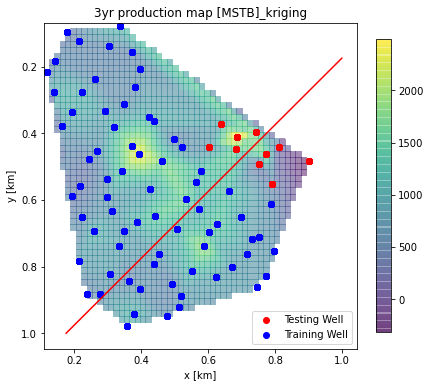

In [36]:
from scipy.interpolate import interp2d
from scipy.interpolate import LinearNDInterpolator

##Aggregate the data tfor plotting purpuse 
X_data = np.hstack((df_agg_merge_producer_train['X, m'].values, df_agg_preProducer['X, m'].values))
Y_data = np.hstack((df_agg_merge_producer_train['Y, m'].values, df_agg_preProducer['Y, m'].values))
Z_data = np.hstack((df_agg_merge_producer_target.values, result))

X_prod3 = np.linspace(min(X_data), max(X_data))
Y_prod3 = np.linspace(min(Y_data), max(Y_data))
X_prod3, Y_prod3 = np.meshgrid(X_prod3, Y_prod3) 
interp = LinearNDInterpolator(list(zip(X_data, Y_data)), Z_data)
Z_prod3 = interp(X_prod3, Y_prod3)

fig, ax = plt.subplots(figsize = (7, 6))
im0 = ax.pcolormesh(X_prod3, Y_prod3, Z_prod3, shading='auto', alpha = 0.5) 
ax.plot([10000/10000, 1750/10000], [1750/10000, 10000/10000], 'r')
im1 = ax.scatter(df_preProducer_imputed_scale['X, m'], df_preProducer_imputed_scale['Y, m'], c = 'red')
im2 = ax.scatter(df_producer_imputed_scale['X, m'], df_producer_imputed_scale['Y, m'], c = 'blue')


ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('3yr production map [MSTB]_kriging')
ax.legend([im1, im2], ['Testing Well', 'Training Well'])

fig.colorbar(im0, ax = ax, shrink=0.9)
plt.gca().invert_yaxis()

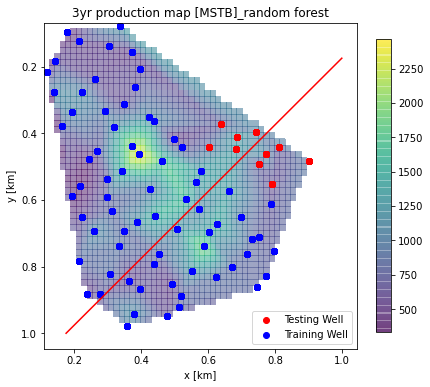

In [37]:
from scipy.interpolate import interp2d
from scipy.interpolate import LinearNDInterpolator

##Aggregate the data tfor plotting purpuse 
X_data = np.hstack((df_agg_merge_producer_train['X, m'].values, df_agg_preProducer['X, m'].values))
Y_data = np.hstack((df_agg_merge_producer_train['Y, m'].values, df_agg_preProducer['Y, m'].values))
Z_data = np.hstack((df_agg_merge_producer_target.values, result2))

X_prod3 = np.linspace(min(X_data), max(X_data))
Y_prod3 = np.linspace(min(Y_data), max(Y_data))
X_prod3, Y_prod3 = np.meshgrid(X_prod3, Y_prod3) 
interp = LinearNDInterpolator(list(zip(X_data, Y_data)), Z_data)
Z_prod3 = interp(X_prod3, Y_prod3)

fig, ax = plt.subplots(figsize = (7, 6))
im0 = ax.pcolormesh(X_prod3, Y_prod3, Z_prod3, shading='auto', alpha = 0.5) 
ax.plot([10000/10000, 1750/10000], [1750/10000, 10000/10000], 'r')
im1 = ax.scatter(df_preProducer_imputed_scale['X, m'], df_preProducer_imputed_scale['Y, m'], c = 'red')
im2 = ax.scatter(df_producer_imputed_scale['X, m'], df_producer_imputed_scale['Y, m'], c = 'blue')

#Plotting Well Number
#wellNumberMarker = [x.split("_")[-1] for x in df_producer['Well_ID'].values]
#for i, txt in enumerate(wellNumberMarker):
#    ax.annotate(txt, ((df_producer['X, m'][i], df_producer['Y, m'][i])))
#wellNumberMarker = [x.split("_")[-1] for x in df_preProc['Well_ID'].values]
#for i, txt in enumerate(wellNumberMarker):
#    ax.annotate(txt, ((df_preProc['X, m'][i], df_preProc['Y, m'][i])))

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('3yr production map [MSTB]_random forest')
ax.legend([im1, im2], ['Testing Well', 'Training Well'])

fig.colorbar(im0, ax = ax, shrink=0.9)
plt.gca().invert_yaxis()

In [ ]:
### Please uncooment to run the file
'''
from sklearn.model_selection import GridSearchCV
randomForest_tune = RandomForestRegressor()
parameters = {'n_estimators': [10, 25, 50, 75, 100], 'max_depth': [5, 7, 12, 17, 25, 30]}
clf = GridSearchCV(randomForest_tune, parameters, verbose = 3, scoring = 'neg_mean_absolute_error')

clf.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)

from sklearn.ensemble import GradientBoostingRegressor
XGboost_tune = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [5, 10, 25, 50, 100], 'max_depth': [2, 4, 6, 8]}
clf_XG = GridSearchCV(XGboost_tune, parameters, scoring = 'neg_mean_absolute_error', verbose = 3)
clf_XG.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)

from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
print(cross_val_score(linearReg, df_agg_merge_producer_train, df_agg_merge_producer_target, scoring='neg_mean_absolute_error').mean())
'''


Optimal number of features : 5


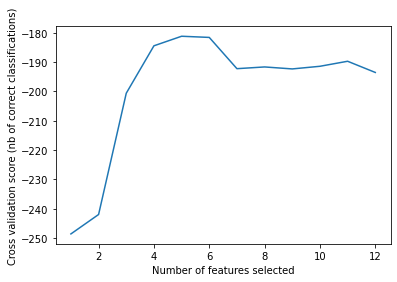

[ 0  5  6  7  9 10 11]


In [38]:

## Recursive feature slection -- random forest 
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
RF_feature = RandomForestRegressor(max_depth = 7, n_estimators = 100)

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=RF_feature, step=1, cv = 5,
              scoring='neg_mean_absolute_error',
              min_features_to_select = min_features_to_select)
rfecv.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

print(np.where(rfecv.support_ == False)[0])

In [39]:
### Fine tuning random forest
from sklearn.model_selection import GridSearchCV
RF_featureImportance = RandomForestRegressor(max_depth = 7, n_estimators = 100)

RF_featureImportance.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)

RandomForestRegressor(max_depth=7)

<BarContainer object of 12 artists>

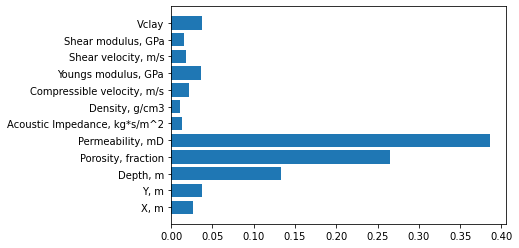

In [40]:
plt.figure()
plt.barh(df_agg_merge_producer_train.columns, RF_featureImportance.feature_importances_)

In [41]:
## Try dropping the data frame 
X = df_agg_merge_producer_train.copy()
X_test = df_agg_preProducer.copy()

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

Optimal number of features : 8


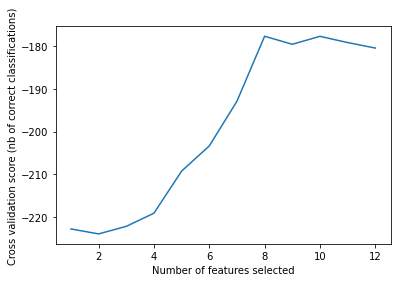

[ 0  1  9 11]


In [42]:
## Recursive feature slection -- Linear regression 
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Create the RFE object and compute a cross-validated score.
linearReg = LinearRegression()

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=linearReg, step=1, cv = 5,
              scoring='neg_mean_absolute_error',
              min_features_to_select = min_features_to_select)

rfecv.fit(df_agg_merge_producer_train, df_agg_merge_producer_target)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

print(np.where(rfecv.support_ == False)[0])

<AxesSubplot:>

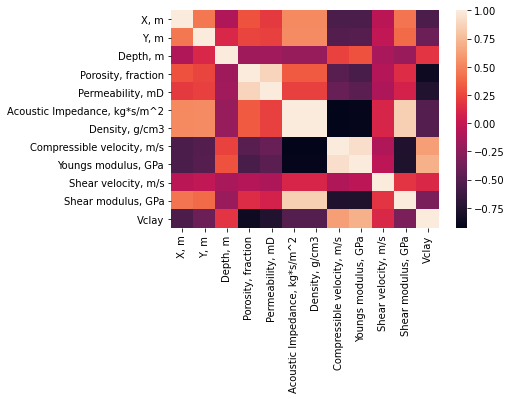

In [43]:
sns.heatmap(df_agg_merge_producer_train.corr())

In [44]:
## Try dropping the data frame 
X = df_agg_merge_producer_train.copy()
X_test = df_agg_preProducer.copy()

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_test.drop(X_test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

linearReg = LinearRegression(normalize=True)
print(cross_val_score(linearReg, X, df_agg_merge_producer_target, scoring='neg_mean_absolute_error').mean())

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, df_agg_merge_producer_target, test_size=0.33, random_state=42)  
# Fitting line without spliting test-train gives similar results 

linearReg.fit(X, df_agg_merge_producer_target)
result4 = linearReg.predict(X_test)

-177.87297559462303


<BarContainer object of 8 artists>

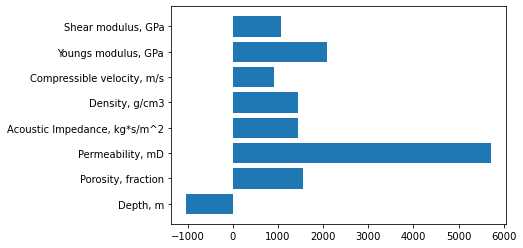

In [45]:
plt.figure()
plt.barh(X.columns, linearReg.coef_)

## 4. Uncertainty analysis

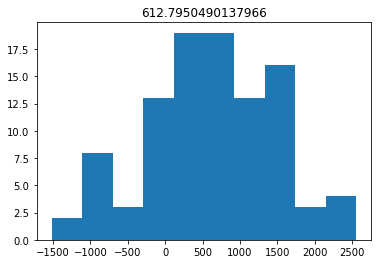

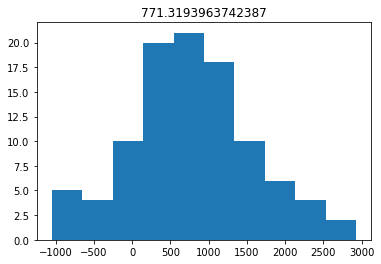

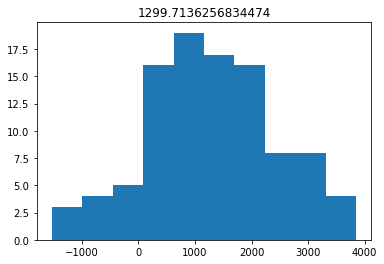

In [46]:
## Uncertainty analysis  --- Multivarient drawing --> The linear regression model is not good because it gives  negative values 
import random 
N = 20000      #number of picked point 
predictionALL = []
keyFeature = ['Depth, m', 'Porosity, fraction', 'Permeability, mD', 'Acoustic Impedance, kg*s/m^2', 'Density, g/cm3',
             'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear modulus, GPa']

for wellNum in range(74, 84):
    
    if wellNum >= 77:
        break 
    
    wellName = "Well_no_{}".format(wellNum)
    
    #masking the data
    df = df_preProducer_imputed_scale[df_preProducer_imputed_scale["Well_ID"] == wellName]
    
    covMatrix = np.cov(df[keyFeature].dropna(), rowvar=False)
    meanVal = df[keyFeature].dropna().mean()
    X_boostrap = np.random.multivariate_normal(meanVal, covMatrix, size=100)    
    
    yPred = linearReg.predict(X_boostrap)
    plt.figure()
    plt.hist(yPred)
    plt.title("{}".format(np.mean(yPred)))

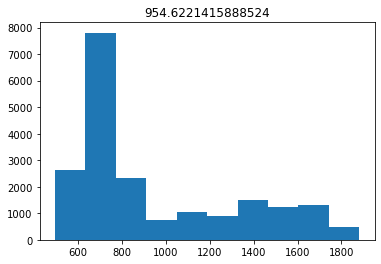

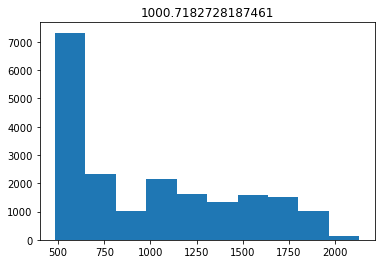

In [47]:
## Uncertainty analysis  --- Multivarient drawing  -- random forest <-- This is why we use this.
import random 
N = 20000      #number of picked point 
predictionALL = np.zeros((10, N))
keyFeature = ['Depth, m', 'Porosity, fraction', 'Permeability, mD', 'Acoustic Impedance, kg*s/m^2', 'Density, g/cm3',
             'Compressible velocity, m/s', 'Youngs modulus, GPa', 'Shear modulus, GPa']
i = 0
for wellNum in range(74, 84):
    
    wellName = "Well_no_{}".format(wellNum)
    
    #masking the data
    df = df_preProducer_imputed_scale[df_preProducer_imputed_scale["Well_ID"] == wellName].drop("Well_ID", axis = 1)
    
    covMatrix = np.cov(df.dropna(), rowvar=False)
    meanVal = df.dropna().mean()
    X_boostrap = np.random.multivariate_normal(meanVal, covMatrix, size=N)    
    
    yPred = RF_featureImportance.predict(X_boostrap)
    
    predictionALL[i, :] = yPred
    i = i + 1
    if wellNum < 76:
        plt.figure()
        plt.hist(yPred)
        plt.title("{}".format(np.mean(yPred)))

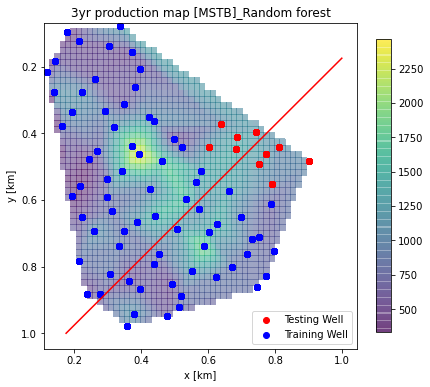

In [48]:
##### Final result ####

from scipy.interpolate import interp2d
from scipy.interpolate import LinearNDInterpolator

##Aggregate the data tfor plotting purpuse 
X_data = np.hstack((df_agg_merge_producer_train['X, m'].values, df_agg_preProducer['X, m'].values))
Y_data = np.hstack((df_agg_merge_producer_train['Y, m'].values, df_agg_preProducer['Y, m'].values))
Z_data = np.hstack((df_agg_merge_producer_target.values, predictionALL.mean(axis = 1)))

X_prod3 = np.linspace(min(X_data), max(X_data))
Y_prod3 = np.linspace(min(Y_data), max(Y_data))
X_prod3, Y_prod3 = np.meshgrid(X_prod3, Y_prod3) 
interp = LinearNDInterpolator(list(zip(X_data, Y_data)), Z_data)
Z_prod3 = interp(X_prod3, Y_prod3)

fig, ax = plt.subplots(figsize = (7, 6))
im0 = ax.pcolormesh(X_prod3, Y_prod3, Z_prod3, shading='auto', alpha = 0.5) 
ax.plot([10000/10000, 1750/10000], [1750/10000, 10000/10000], 'r')
im1 = ax.scatter(df_preProducer_imputed_scale['X, m'], df_preProducer_imputed_scale['Y, m'], c = 'red')
im2 = ax.scatter(df_producer_imputed_scale['X, m'], df_producer_imputed_scale['Y, m'], c = 'blue')

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('3yr production map [MSTB]_Random forest')
ax.legend([im1, im2], ['Testing Well', 'Training Well'])

fig.colorbar(im0, ax = ax, shrink=0.9)
plt.gca().invert_yaxis()

In [49]:
finalSolution = []
for i in range(10):
    finalSolution.append(np.percentile(predictionALL[i, :], range(1, 101)))

finalSolution = np.array(finalSolution)
finalSolution = np.hstack((predictionALL.mean(axis = 1)[:, np.newaxis], finalSolution))



In [ ]:
#pd.DataFrame(finalSolution).to_csv("solution.csv")